# Sktime workshop: Pycon Colombia 2025 (Part 3)


## 3.1. Loading the data

In [ ]:
import pandas as pd

In [1]:
from pycon_workshop.dataset import PyConWorkshopDataset

dataset = PyConWorkshopDataset("hierarchical")
y_train, y_test = dataset.load("y_train", "y_test")

In [2]:
y_train

sales
group_id sku_id date             
-1       20     2020-01-01      0
                2020-01-02      4
                2020-01-03      4
                2020-01-04      6
                2020-01-05      2
...                           ...
 3       19     2024-07-01     25
                2024-07-02     14
                2024-07-03     13
                2024-07-04     30
                2024-07-05     51

[41200 rows x 1 columns]

In [3]:
y_train.index.droplevel(-1).nunique()

25

### Aggregating

We add total levels to the dataset.

In sktime, totals have the special keyword `__total`.

In [4]:
from sktime.transformations.hierarchical.aggregate import Aggregator

y_train = Aggregator().fit_transform(y_train)
y_test = Aggregator().fit_transform(y_test)
y_train


sales
group_id sku_id  date             
-1       20      2020-01-01      0
                 2020-01-02      4
                 2020-01-03      4
                 2020-01-04      6
                 2020-01-05      2
...                            ...
__total  __total 2024-07-01   2190
                 2024-07-02   2162
                 2024-07-03   2129
                 2024-07-04   2661
                 2024-07-05   2430

[51088 rows x 1 columns]

In [112]:
y_train.loc[(-1, "__total")]

,sales
date,
2020-01-01,3
2020-01-02,9
2020-01-03,12
2020-01-04,15
2020-01-05,9
...,...
2024-07-01,763
2024-07-02,841
2024-07-03,858


In [5]:
y_train.index.droplevel(-1).nunique()

31

## 3.2. Forecasting

In [6]:
fh = y_test.index.get_level_values(-1).unique()

In [113]:
from prophetverse import Prophetverse, PiecewiseLinearTrend, MAPInferenceEngine, LinearFourierSeasonality


forecaster = Prophetverse(
    trend=PiecewiseLinearTrend(changepoint_interval=365),
    exogenous_effects=[
        (
            "seasonality",
            LinearFourierSeasonality(
                sp_list=[365.25, 7],
                fourier_terms_list=[10, 3],
                effect_mode="multiplicative",
                freq="D"
                ),
            None
        )
    ],
    inference_engine=MAPInferenceEngine()
)

In [63]:
parallel_config = {
        "backend:parallel": "joblib",
        "backend:parallel:params": {"backend": "loky", "n_jobs": -1},
}

forecaster.set_config(
    **parallel_config
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh)

**Problem: the bottom forecasts and the total forecasts are not coherent.**

In [87]:
Aggregator().fit_transform(y_pred) - y_pred

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/sktime/transformations/hierarchical/aggregate.py:121: UserWarning: Found elements in the index of X named '__total'. Removing these levels and aggregating.
  warn(


sales
group_id sku_id  date                 
-1       20      2024-07-06   0.000000
                 2024-07-07   0.000000
                 2024-07-08   0.000000
                 2024-07-09   0.000000
                 2024-07-10   0.000000
...                                ...
__total  __total 2024-12-28  24.663818
                 2024-12-29  23.590088
                 2024-12-30  18.972656
                 2024-12-31  19.603516
                 2025-01-01  20.036865

[5580 rows x 1 columns]

## 3.3. Forecast reconciliation

![](imgs/hierarchical_reconciled_vs_not.png)

### Methods

There are different methods to reconcile forecasts in hierarchical time series.
There is no silver bullet, and the best method depends on the data and the context.

#### Bottom-up

<img src="imgs/hierarchical_bottomup.png" alt="Hierarchical Bottom-up" width="450">

#### Top-down (forecast proportions)

<img src="imgs/hierarchical_td_fcst.png" alt="Topdown Forecast" width="900">

#### Optimal reconciliation


* **OLS** : project the base forecasts into the reconciliation space.
* **Weighted OLS**: project all base forecasts into the reconciliation space, but with different weights.
* **Minimum trace (MinT)**: use the error covariance matrix to find the optimal reconciled forecasts. Called "optimal".



In [106]:
from sktime.transformations.hierarchical.reconcile import (
    BottomUpReconciler,
    TopdownReconciler,
    OptimalReconciler
)

bottom_up = BottomUpReconciler() * forecaster
top_down_fcst = TopdownReconciler() * forecaster
optimal = OptimalReconciler("ols", alpha=100) * forecaster

In [107]:
bottom_up.fit(y_train)
top_down_fcst.fit(y_train)
optimal.fit(y_train)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/sktime/transformations/hierarchical/aggregate.py:121: UserWarning: Found elements in the index of X named '__total'. Removing these levels and aggregating.
  warn(
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/sktime/transformations/hierarchical/aggregate.py:121: UserWarning: Found elements in the index of X named '__total'. Removing these levels and aggregating.
  warn(
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-worksh

TransformedTargetForecaster(steps=[OptimalReconciler(alpha=100,
                                                     error_covariance_matrix='ols'),
                                   Prophetverse(exogenous_effects=[('seasonality',
                                                                    LinearFourierSeasonality(effect_mode='multiplicative',
                                                                                             fourier_terms_list=[10,
                                                                                                                 3],
                                                                                             freq='D',
                                                                                             sp_list=[365.25,
                                                                                                      7]),
                                                                    None)],
                                                inference_engine=MAPInferenceEngine(),
                                                trend=PiecewiseLinearTrend(changepoint_interval=365))])

In [108]:
y_pred_bottomup = bottom_up.predict(fh=fh)
y_pred_topdown = top_down_fcst.predict(fh=fh)
y_pred_optimal = optimal.predict(fh=fh)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/sktime/transformations/hierarchical/aggregate.py:121: UserWarning: Found elements in the index of X named '__total'. Removing these levels and aggregating.
  warn(
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/sktime/transformations/hierarchical/aggregate.py:121: UserWarning: Found elements in the index of X named '__total'. Removing these levels and aggregating.
  warn(


In [109]:
Aggregator().fit_transform(y_pred_bottomup) - y_pred_bottomup

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/sktime/transformations/hierarchical/aggregate.py:121: UserWarning: Found elements in the index of X named '__total'. Removing these levels and aggregating.
  warn(


sales
group_id sku_id  date             
-1       20      2024-07-06    0.0
                 2024-07-07    0.0
                 2024-07-08    0.0
                 2024-07-09    0.0
                 2024-07-10    0.0
...                            ...
__total  __total 2024-12-28    0.0
                 2024-12-29    0.0
                 2024-12-30    0.0
                 2024-12-31    0.0
                 2025-01-01    0.0

[5580 rows x 1 columns]

In this case, there's not a lot of difference between the reconciliation outputs.
But we will see that the bottom-up approach is the most accurate one.

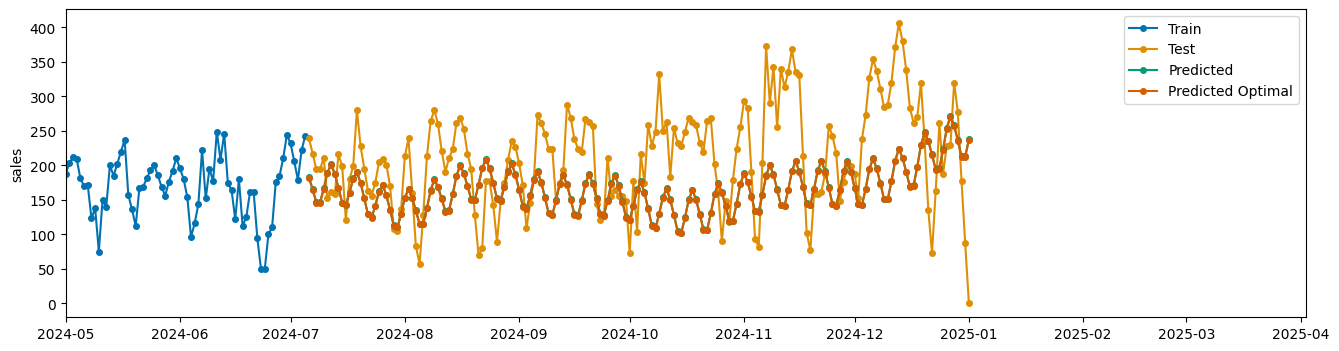

In [110]:
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd


idx = y_train.index.droplevel(-1).unique()[10]

plot_series(
    y_train.loc[idx,], y_test.loc[idx,], y_pred.loc[idx,], y_pred_optimal.loc[idx,],
    labels=["Train", "Test", "Predicted", "Predicted Optimal"],
)
plt.xlim(pd.to_datetime("2024-05-01"), None)
plt.show()

In [105]:
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

metric = MeanSquaredScaledError(multilevel="uniform_average_time")

pd.DataFrame(
    {   
        "Baseline": metric(y_test, y_pred, y_train=y_train),
        "BottomUpReconciler": metric(y_test, y_pred_bottomup, y_train=y_train),
        "TopDownReconciler": metric(y_test, y_pred_topdown, y_train=y_train),
        "OptimalReconciler": metric(y_test, y_pred_optimal, y_train=y_train),
    },
    index=["Mean Absolute Scaled Error"]
)

,Baseline,BottomUpReconciler,TopDownReconciler,OptimalReconciler
Mean Absolute Scaled Error,47.64479,46.097801,47.730192,47.626366
